# Functions that will work on the background

## Image Segmentation

### Get bounding boxes from image from user interaction

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from PIL import Image

In [5]:
rect_start = None
rect_end = None
drawing = False

In [6]:
def draw_rectangle(event, x, y, flags, param):
    """Mouse callback function to draw a rectangle."""
    global rect_start, rect_end, drawing

    if event == cv2.EVENT_LBUTTONDOWN:
        rect_start = (x, y)
        drawing = True

    elif event == cv2.EVENT_LBUTTONUP:
        rect_end = (x, y)
        drawing = False
        cv2.rectangle(img_display, rect_start, rect_end, (255, 0, 0), 4)
        cv2.imshow("Draw Rectangle", img_display)

In [7]:
def interactive_bbox_selection(image_path, window_width=800, window_height=800):
    """Allows the user to draw a rectangle and converts to Ultralytics BBox format."""
    global img_display
    
    # Load image
    img = cv2.imread(image_path)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_display = img.copy()

    cv2.namedWindow("Draw Rectangle", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("Draw Rectangle", window_width, window_height)  # Resize window

    # Set mouse callback
    cv2.setMouseCallback("Draw Rectangle", draw_rectangle)

    while True:
        cv2.imshow("Draw Rectangle", img_display)
        key = cv2.waitKey(1) & 0xFF
        if key == 13:  # Press 'Enter' to finish
            break

    cv2.destroyAllWindows()

    # Convert to Ultralytics BBox format (normalized)
    if rect_start and rect_end:
        x1, y1 = rect_start
        x2, y2 = rect_end

        # Ensure coordinates are sorted properly
        x_min, y_min = min(x1, x2), min(y1, y2)
        x_max, y_max = max(x1, x2), max(y1, y2)

        # Convert to Ultralytics normalized BBox format
        coord = [
            x_min,
            y_min,
            x_max,
            y_max
        ]
        
        print("Coordinates:", coord)
        return coord
    else:
        print("No rectangle was drawn.")
        return None

In [10]:
coord = interactive_bbox_selection("frames/frame_0000.png")

Coordinates: [123, 65, 948, 1673]


### Segment image based on rectangle coordinates


image 1/1 c:\Users\gusta\Documents\Projetos Diversao\MiniAid\test_image.jpg: 640x640 1 0, 4251.6ms
Speed: 7.5ms preprocess, 4251.6ms inference, 80.9ms postprocess per image at shape (1, 3, 640, 640)


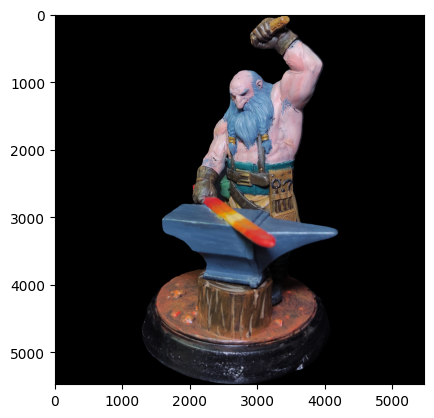

In [9]:
from ultralytics import SAM
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

source = "test_image.jpg"

model = SAM("sam_l.pt")

results = model(source,
                device="cpu",
                retina_masks=True,
                imgsz=640,
                conf=0.2,
                iou=0.4,
                bboxes=[206, 259, 3293, 5996])

for result in results:
    img = np.copy(result.orig_img)

    for ci, c in enumerate(result):
        b_mask = np.zeros(img.shape[:2], np.uint8)

        # Create contour mask 
        contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
        _ = cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)

        isolated = img.copy()
        isolated[b_mask == 0] = 0

        contour = contour.reshape(-1, 2)

        x_min, y_min = np.min(contour, axis=0)
        x_max, y_max = np.max(contour, axis=0)

        # Crop the image to get only the segmented
        cropped_image = isolated[y_min:y_max, x_min:x_max]
        resultado_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

        # Make the image square and centralize the segmented image
        height, width, _ = resultado_rgb.shape
        size = max(height, width)
        square_image = np.zeros((size, size, 3), dtype=np.uint8)

        # Calculate the top-left corner to centralize the image
        y_offset = (size - height) // 2
        x_offset = (size - width) // 2

        square_image[y_offset:y_offset + height, x_offset:x_offset + width] = resultado_rgb

        plt.imshow(square_image)

Making it a function

In [8]:
def segmenting_image(coordinates, model, source):
    results = model(source,
                    device="cuda",
                    retina_masks=True,
                    imgsz=640,
                    bboxes=coordinates)
    for result in results:
        img = np.copy(result.orig_img)
        for ci, c in enumerate(result):
            b_mask = np.zeros(img.shape[:2], np.uint8)
            # Create contour mask 
            contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
            cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)
            
            # Create an RGBA image with an alpha channel
            isolated = np.zeros((*img.shape[:2], 4), dtype=np.uint8)
            isolated[..., :3] = img
            isolated[b_mask == 0, 3] = 0  # Set alpha to 0 for background
            isolated[b_mask != 0, 3] = 255  # Set alpha to 255 for the segmented object
            
            contour = contour.reshape(-1, 2)
            x_min, y_min = np.min(contour, axis=0)
            x_max, y_max = np.max(contour, axis=0)
            
            # Crop the image to get only the segmented object
            cropped_image = isolated[y_min:y_max, x_min:x_max]
            
            # Create a square image with 4 channels (RGBA)
            height, width, _ = cropped_image.shape
            size = max(height, width)
            square_image = np.zeros((size, size, 4), dtype=np.uint8)
            
            # Calculate the top-left corner to centralize the image
            y_offset = (size - height) // 2
            x_offset = (size - width) // 2
            
            # Copy the cropped image into the square image
            square_image[y_offset:y_offset + height, x_offset:x_offset + width] = cropped_image
            
            # Save the image with 4 channels (RGBA)
            cv2.imwrite("segmented.png", square_image)
            
            # For display, convert to RGB for matplotlib
            plt.imshow(cv2.cvtColor(square_image, cv2.COLOR_RGBA2BGRA))
            plt.axis('off')
            plt.show()

### Combining everything

Coordinates: [192, 108, 938, 1670]


image 1/1 c:\Users\gnoceras\Documents\GustavoPersonal\MiniAid\frames\frame_0073.png: 640x640 1 0, 2089.4ms
image 1/1 c:\Users\gnoceras\Documents\GustavoPersonal\MiniAid\frames\frame_0073.png: 640x640 1 0, 2089.4ms
Speed: 284.4ms preprocess, 2089.4ms inference, 166.3ms postprocess per image at shape (1, 3, 640, 640)
Speed: 284.4ms preprocess, 2089.4ms inference, 166.3ms postprocess per image at shape (1, 3, 640, 640)


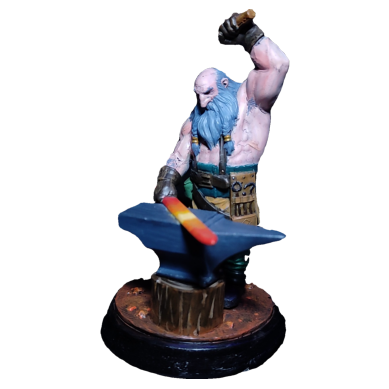

In [9]:
from ultralytics import SAM
%matplotlib inline

rect_start = None
rect_end = None
drawing = False

source = "frames/frame_0073.png"
model = SAM("models/sam_l.pt")

coordinates = interactive_bbox_selection(source)
segmenting_image(coordinates, model, source)

## 3D reconstruction from videos

### Extract frames from Video

In [ ]:
import cv2
import os
from tqdm import tqdm

def extract_frames(video_path, output_folder = "frames", frame_interval = 30):
    """"
    Extract the frames from a video.

    Args:
        video_path (str): The path to the video to be extracted.
        output_folder (str): The path to save the extracted frames.
        frame_interval (int): The interval of frames within the frames will be extracted
    
    Returns:
        Extracted frames will be saved in the output_folder in png format
    
    """

    if not os.path.exists(output_folder):
        os.mkdir(output_folder)

    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    extracted_count = 0
    
    # Get rotation information
    rotation = int(cap.get(cv2.CAP_PROP_ORIENTATION_META))
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print("------ Extracting frames ------")
    
    with tqdm(total=total_frames, unit="frame") as pbar:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            # Apply rotation correction based on metadata
            if rotation == 90:
                frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
            elif rotation == 180:
                frame = cv2.rotate(frame, cv2.ROTATE_180)
            elif rotation == 270:
                frame = cv2.rotate(frame, cv2.ROTATE_90_COUNTERCLOCKWISE)
            
            # Save frame
            if frame_count % frame_interval == 0:
                frame_filename = os.path.join(output_folder, f"frame_{extracted_count:04d}.png")

                cv2.imwrite(frame_filename, frame)
                
                extracted_count += 1
            
            frame_count += 1
            pbar.update(1)
        cap.release()

In [ ]:
extract_frames("videos/Adventurer.mp4", "frames", 30)

### Segmenting Images

In [ ]:
import torch
import numpy as np
import os
from tqdm import tqdm
from ultralytics import SAM

def segmenting_image(input_folder,  output_folder, coordinates):
    
    """"
    Segment the desired image from the extracted video frames.

    Args:
        input_folder (str): The path to the folder containing the video frames.
        output_folder (str): The path to the folder where the segmented images will be savedd.
        coordinates (array): Array with the rectangle coordinates which the desired image is within. The format is [xmin, ymin, xmax, ymax].
    
    Returns:
        Save the segmented images with a black background in the output_folder
    
    """

    model = SAM("models/sam2_l.pt")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if not os.path.exists(output_folder):
        os.mkdir(output_folder)

    print("------ Segmenting images ------")

    for file in tqdm(os.listdir(input_folder), unit="Images"):
        
        results = model.predict(os.path.join(input_folder, file),
                                device=device,
                                imgsz=1024,
                                bboxes=coordinates,
                                conf=0.25,
                                verbose=False)
        
        for result in results:
            img = np.copy(result.orig_img)
            for ci, c in enumerate(result):
                b_mask = np.zeros(img.shape[:2], np.uint8)

                # Create contour mask 
                contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
                cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)

                res = cv2.bitwise_and(img, img, mask=b_mask)
                
                contour = contour.reshape(-1, 2)
                x_min, y_min = np.min(contour, axis=0)
                x_max, y_max = np.max(contour, axis=0)
                
                # Crop the image to get only the segmented object
                cropped_image = res[y_min:y_max, x_min:x_max]
                cv2.imwrite(os.path.join(os.path.join(output_folder, file)), cropped_image)

In [ ]:
coordinates = [123, 65, 948, 1673]
segmenting_image("frames", "segmented_images", coordinates)

### Natural Feature Extraction

In [25]:
import os
import cv2
import numpy as np
import argparse
from pathlib import Path
import matplotlib.pyplot as plt
from math import ceil
from collections import defaultdict
from tqdm import tqdm

In [18]:
def extract_sift_features(image_path, contrast_threshold=0.04, edge_threshold=10, sigma=1.6):
    """
    Extract SIFT features from an image with customizable parameters.
    
    The SIFT algorithm finds distinctive keypoints that are invariant to
    rotation, translation, and scale by:
    1. Building a scale-space pyramid using differences of Gaussians
    2. Finding maxima/minima in this scale-space
    3. Assigning orientations based on local gradient directions
    4. Computing descriptors based on local gradient statistics
    
    Args:
        image_path (str): Path to the image file
        contrast_threshold (float): Threshold for filtering low-contrast keypoints
        edge_threshold (float): Threshold for filtering edge-like keypoints
        sigma (float): Initial Gaussian blur sigma
        
    Returns:
        tuple: (image, keypoints, descriptors)
    """
    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image at {image_path}")
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Create SIFT detector with custom parameters
    # - contrast_threshold: Lower values keep more low-contrast keypoints
    # - edge_threshold: Higher values keep more keypoints near edges
    # - sigma: Controls the initial Gaussian blur
    sift = cv2.SIFT_create(
        contrastThreshold=contrast_threshold,
        edgeThreshold=edge_threshold,
        sigma=sigma
    )
    
    # Detect keypoints and compute descriptors (128-dimensional vectors)
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    
    return img, keypoints, descriptors

In [31]:
def grid_filter_keypoints(keypoints, descriptors, img_shape, grid_size=(16, 16), max_per_cell=5, 
                          min_total=1000, max_total=10000):
    """
    Filter keypoints using a grid to ensure good spatial distribution.
    
    This approach divides the image into a grid and keeps a limited number 
    of strongest keypoints per cell, ensuring features are well-distributed
    across the entire image rather than clustered in highly textured regions.
    
    Args:
        keypoints: List of cv2.KeyPoint objects
        descriptors: NumPy array of descriptors
        img_shape: Tuple (height, width) of the image
        grid_size: Tuple (rows, cols) defining the grid dimensions
        max_per_cell: Maximum number of keypoints to keep per cell
        min_total: Minimum total keypoints to aim for
        max_total: Maximum total keypoints to allow
        
    Returns:
        tuple: (filtered_keypoints, filtered_descriptors)
    """
    if not keypoints:
        return [], None
    
    height, width = img_shape[:2]
    cell_height = height / grid_size[0]
    cell_width = width / grid_size[1]
    
    # Group keypoints by grid cell
    cells = defaultdict(list)
    for i, kp in enumerate(keypoints):
        x, y = kp.pt
        row = min(int(y / cell_height), grid_size[0] - 1)
        col = min(int(x / cell_width), grid_size[1] - 1)
        # Store (keypoint_index, response) for sorting
        cells[(row, col)].append((i, kp.response))
    
    # Sort keypoints in each cell by response (strength) and keep the strongest ones
    filtered_indices = []
    for cell_keypoints in cells.values():
        # Sort by response (descending)
        cell_keypoints.sort(key=lambda x: x[1], reverse=True)
        # Keep at most max_per_cell keypoints per cell
        filtered_indices.extend([idx for idx, _ in cell_keypoints[:max_per_cell]])
    
    # If we have too many keypoints, keep the strongest ones
    if len(filtered_indices) > max_total:
        # Sort indices by keypoint response
        sorted_indices = sorted(filtered_indices, key=lambda i: keypoints[i].response, reverse=True)
        filtered_indices = sorted_indices[:max_total]
    
    # If we have too few keypoints and there were more available, keep more of the strongest ones
    if len(filtered_indices) < min_total and len(keypoints) > len(filtered_indices):
        # Get the indices that weren't included
        all_indices = set(range(len(keypoints)))
        remaining_indices = list(all_indices - set(filtered_indices))
        # Sort by response
        remaining_indices.sort(key=lambda i: keypoints[i].response, reverse=True)
        # Add more keypoints up to min_total or as many as available
        additional_count = min(min_total - len(filtered_indices), len(remaining_indices))
        filtered_indices.extend(remaining_indices[:additional_count])
    
    # Create new lists for filtered keypoints and descriptors
    filtered_keypoints = [keypoints[i] for i in filtered_indices]
    
    if descriptors is not None:
        filtered_descriptors = descriptors[filtered_indices]
    else:
        filtered_descriptors = None
    
    return filtered_keypoints, filtered_descriptors

In [38]:
def visualize_features(img, keypoints, output_path=None, show_grid=False, grid_size=(16, 16)):
    """
    Visualize the SIFT features on the image, optionally with grid overlay.
    
    Args:
        img: Original image
        keypoints: Detected keypoints
        output_path: Path to save the visualization (optional)
        show_grid: Whether to overlay the grid used for filtering
        grid_size: The grid dimensions used for filtering
    """
    # Draw keypoints on the image
    img_with_keypoints = cv2.drawKeypoints(img, keypoints, None, 
                                          flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    # Convert from BGR to RGB for matplotlib
    img_with_keypoints_rgb = cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB)
    
    # Display the image
    plt.figure(figsize=(12, 10))
    plt.imshow(img_with_keypoints_rgb)
    
    # Draw grid if requested
    if show_grid:
        height, width = img.shape[:2]
        cell_height = height / grid_size[0]
        cell_width = width / grid_size[1]
        
        # Draw horizontal lines
        for i in range(1, grid_size[0]):
            y = i * cell_height
            plt.axhline(y=y, color='r', linestyle='-', alpha=0.3)
        
        # Draw vertical lines
        for i in range(1, grid_size[1]):
            x = i * cell_width
            plt.axvline(x=x, color='r', linestyle='-', alpha=0.3)
    
    plt.title(f'SIFT Features: {len(keypoints)} keypoints')
    plt.axis('off')
    

    # Save the image if output path is provided
    if output_path:
        plt.savefig(output_path, bbox_inches='tight', dpi=300)
        plt.close()
    else:
        plt.show()

In [39]:
def natural_feature_extraction(input_folder, output_folder=None, visualize=True, grid_filter=True,
                                grid_size=(16, 16), max_per_cell=20, min_total=1000, max_total=10000,
                                contrast_threshold=0.04, edge_threshold=10, sigma=1.6):
    """
    Process all images in a folder and extract SIFT features.
    
    Args:
        input_folder (str): Path to the folder containing images
        output_folder (str): Path to save the visualizations and data (optional)
        visualize (bool): Whether to visualize and save feature images
        grid_filter (bool): Whether to use grid filtering for keypoint distribution
        grid_size (tuple): Dimensions of the grid for filtering (rows, cols)
        max_per_cell (int): Maximum keypoints to keep per grid cell
        min_total (int): Minimum total keypoints to aim for
        max_total (int): Maximum total keypoints to allow
        contrast_threshold (float): Threshold for filtering low-contrast keypoints
        edge_threshold (float): Threshold for filtering edge-like keypoints
        sigma (float): Initial Gaussian blur sigma
    
    Returns:
        dict: Dictionary mapping image names to their features
    """
    # Create output folder if needed
    if output_folder and not os.path.exists(output_folder):
        os.makedirs(output_folder)
        os.makedirs(os.path.join(output_folder, 'visualizations'), exist_ok=True)
        os.makedirs(os.path.join(output_folder, 'data'), exist_ok=True)
    
    # Dictionary to store features
    all_features = {}
    
    # Get all image files
    image_paths = [f for f in Path(input_folder).glob('**/*')]
    
    print(f"Found {len(image_paths)} images in {input_folder}")
    
    # Process each image
    for i, image_path in enumerate(tqdm(image_paths, unit="Images")):
        try:
            # Extract initial features
            img, keypoints, descriptors = extract_sift_features(
                str(image_path),
                contrast_threshold=contrast_threshold,
                edge_threshold=edge_threshold,
                sigma=sigma
            )
            
            original_count = len(keypoints) if keypoints else 0
            
            # Apply grid filtering if requested
            if grid_filter and keypoints:
                keypoints, descriptors = grid_filter_keypoints(
                    keypoints, descriptors, img.shape, 
                    grid_size=grid_size,
                    max_per_cell=max_per_cell,
                    min_total=min_total,
                    max_total=max_total
                )
            
            # Store features
            all_features[image_path.name] = {
                'keypoints': keypoints,
                'descriptors': descriptors,
                'num_features': len(keypoints) if keypoints else 0,
                'original_count': original_count
            }
            
            # Create visualizations and analysis if requested
            if visualize and output_folder and keypoints:
                # Main visualization with keypoints
                vis_path = os.path.join(output_folder, 'visualizations', f"{image_path.stem}_sift.png")
                visualize_features(img, keypoints, vis_path, show_grid=grid_filter, grid_size=grid_size)
            
            # Save descriptors and keypoints as numpy array
            if output_folder and keypoints and descriptors is not None:
                
                # Descriptors
                desc_path = os.path.join(output_folder, 'data', f"{image_path.stem}_descriptors.npy")
                np.save(desc_path, descriptors)
                
                # Keypoint information separately (cv2.KeyPoint objects can't be directly saved)
                keypoints_data = [(kp.pt, kp.size, kp.angle, kp.response, kp.octave, kp.class_id) 
                                  for kp in keypoints]
                kp_path = os.path.join(output_folder, 'data', f"{image_path.stem}_keypoints.npy")
                np.save(kp_path, np.array(keypoints_data, dtype=object))
            
        except Exception as e:
            print(f"Error processing {image_path.name}: {e}")
    
    # Save summary of features
    if output_folder:
        with open(os.path.join(output_folder, 'feature_summary.txt'), 'w') as f:
            f.write("Image Name, Original Keypoints, Filtered Keypoints, Reduction %\n")
            for name, features in all_features.items():
                original = features['original_count']
                filtered = features['num_features']
                reduction = ((original - filtered) / original * 100) if original > 0 else 0
                f.write(f"{name}, {original}, {filtered}, {reduction:.1f}%\n")
    
    return all_features

In [40]:
natural_feature_extraction("segmented_images", "SIFT_output")

Found 34 images in segmented_images


100%|██████████| 34/34 [00:36<00:00,  1.07s/Images]


{'frame_0000.png': {'keypoints': [< cv2.KeyPoint 0000020BC107A1F0>,
   < cv2.KeyPoint 0000020BC1079590>,
   < cv2.KeyPoint 0000020BC10785A0>,
   < cv2.KeyPoint 0000020BC10796B0>,
   < cv2.KeyPoint 0000020BC1078960>,
   < cv2.KeyPoint 0000020BC1078ED0>,
   < cv2.KeyPoint 0000020BC107A850>,
   < cv2.KeyPoint 0000020BC1078F90>,
   < cv2.KeyPoint 0000020BC107A2E0>,
   < cv2.KeyPoint 0000020BC1079C20>,
   < cv2.KeyPoint 0000020BC107A7F0>,
   < cv2.KeyPoint 0000020BC107AD60>,
   < cv2.KeyPoint 0000020BC107B660>,
   < cv2.KeyPoint 0000020BC107ACD0>,
   < cv2.KeyPoint 0000020BC107A430>,
   < cv2.KeyPoint 0000020BC107B990>,
   < cv2.KeyPoint 0000020BC1078F30>,
   < cv2.KeyPoint 0000020BC10782A0>,
   < cv2.KeyPoint 0000020BC107BE10>,
   < cv2.KeyPoint 0000020BC107A370>,
   < cv2.KeyPoint 0000020BC1079BC0>,
   < cv2.KeyPoint 0000020BC1078750>,
   < cv2.KeyPoint 0000020BC107A220>,
   < cv2.KeyPoint 0000020BC107BB10>,
   < cv2.KeyPoint 0000020BC1088330>,
   < cv2.KeyPoint 0000020BC10837E0>,
   < cv

### Building 3D models from 2D images

#### Libraries import

In [3]:
from matplotlib import pyplot as plt
from PIL import Image
import torch
import numpy as np
import open3d as o3d
import glob
import cv2

#### Getting Model

In [4]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

feature_extractor = AutoImageProcessor.from_pretrained("depth-anything/Depth-Anything-V2-Large-hf")
model = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Large-hf").to(device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


#### Loading and resizing the image

In [5]:
image = Image.open("frames/frame_0000.png")

new_height = 480 if image.height > 480 else image.height
new_height -= (new_height % 32)
new_width = int(new_height * image.width / image.height)
diff = new_width % 32

new_width = new_width - diff if diff < 16 else new_width + 32 - diff
new_size = (new_width, new_height)
image = image.resize(new_size)

#### Preparing the image for the model

In [6]:
inputs = feature_extractor(images=image, return_tensors="pt").to(device)

#### Getting the prediction

In [7]:
with torch.no_grad():
    outputs = model(**inputs)
    
predicted_depth = feature_extractor.post_process_depth_estimation(
    outputs, target_sizes=[(image.height, image.width)],
)

#### Post-processing

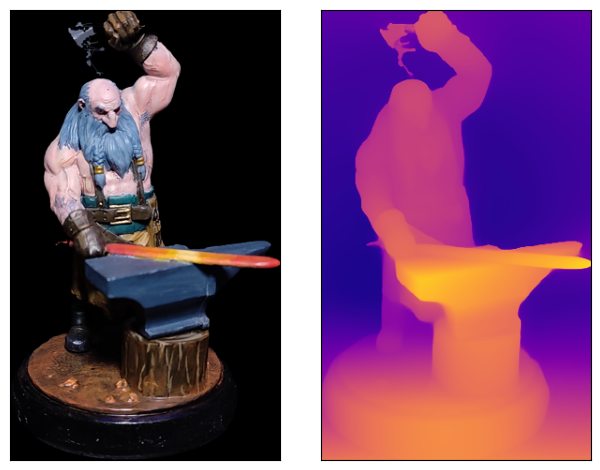

In [8]:
depth = predicted_depth[0]["predicted_depth"]
depth = (depth - depth.min()) / (depth.max() - depth.min())
depth = depth * 255.
depth = depth.detach().cpu().numpy()

fig, ax = plt.subplots(1, 2)
ax[0].imshow(image)
ax[0].tick_params(left=False, bottom=False, labelleft = False, labelbottom=False)
ax[1].imshow(depth, cmap="plasma")
ax[1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.tight_layout()
plt.show()

#### Preparing the depth image for open3d

In [9]:
width, height = image.size

depth_image = (depth * 255 / np.max(depth)).astype('uint8')
image = np.array(image)

depth_o3d = o3d.geometry.Image(depth_image)
image_o3d = o3d.geometry.Image(image)
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(image_o3d,
                                                                depth_o3d,
                                                                convert_rgb_to_intensity=False)

#### Creating a camera

Processing calibration_images\IMG_20250323_153234.jpg
Chessboard found!


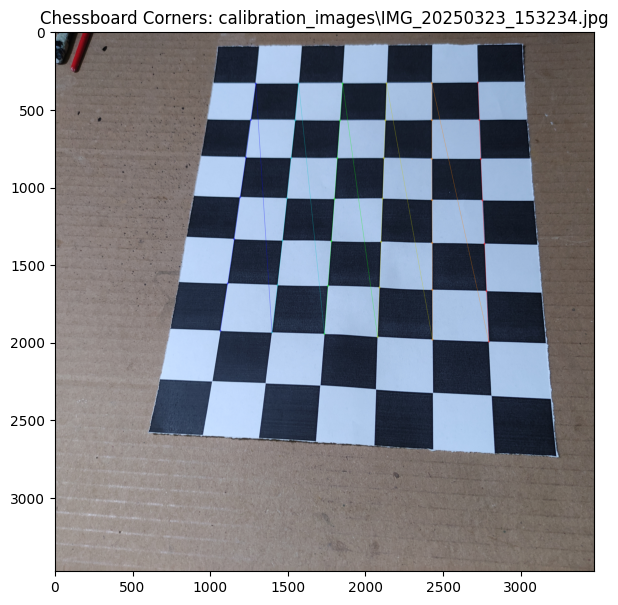

Processing calibration_images\IMG_20250323_153240.jpg
No Chessboard Found in calibration_images\IMG_20250323_153240.jpg


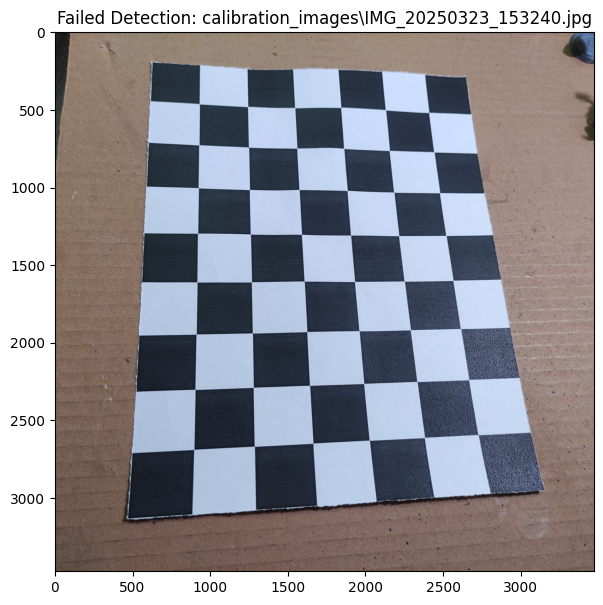

Processing calibration_images\IMG_20250323_153245.jpg
Chessboard found!


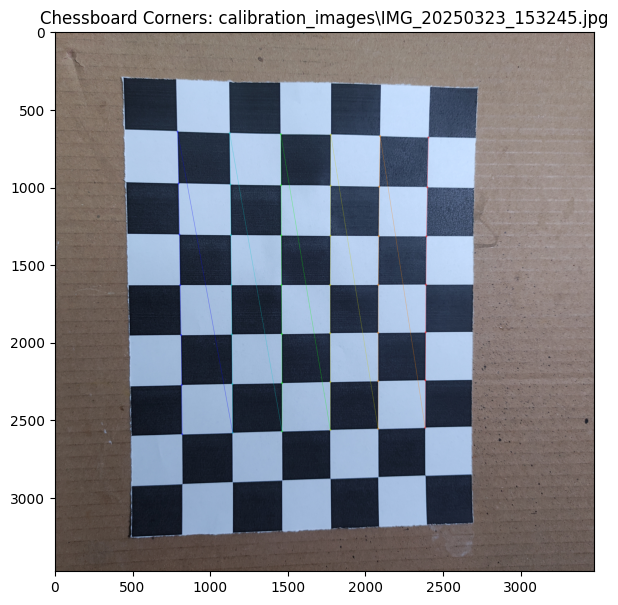

In [22]:
# Define the dimensions of checkerboard
chessboard_size = (7, 6)
square_size = 2.5

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Prepare object points (0,0,0), (1,0,0), (2,0,0) ....,(8,6,0)
objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)
objp *= square_size  # Convert to real world units

# Arrays to store object points and image points
objpoints = []  # 3D points in real world space
imgpoints = []  # 2D points in image plane

# Get list of calibration images
images = glob.glob("calibration_images/*.jpg")

for fname in images:
    print(f"Processing {fname}")
    
    # Read the image
    img = cv2.imread(fname)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(
        gray, 
        chessboard_size, 
        None
    )
    
    # If found, refine the corners
    if ret:
        print("Chessboard found!")
        
        # Refine corner positions
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        
        # Add to our collections
        objpoints.append(objp)
        imgpoints.append(corners2)
        
        # Draw and display the corners
        img_corners = cv2.drawChessboardCorners(img.copy(), chessboard_size, corners2, ret)
        
        # Display the result
        plt.figure(figsize=(10, 7))
        plt.imshow(cv2.cvtColor(img_corners, cv2.COLOR_BGR2RGB))
        plt.title(f"Chessboard Corners: {fname}")
        plt.show()
    else:
        print(f"No Chessboard Found in {fname}")
        
        # Display the original image for debugging
        plt.figure(figsize=(10, 7))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Failed Detection: {fname}")
        plt.show()

In [23]:
# Calibrate the camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

if ret:
    print("Camera calibration successful!")
    print("Intrinsic matrix (mtx):")
    print(mtx)
    print("Distortion coefficients (dist):")
    print(dist)

    # Extract intrinsic parameters
    fx = mtx[0, 0]
    fy = mtx[1, 1]
    cx = mtx[0, 2]
    cy = mtx[1, 2]

    print(f"Focal length (fx, fy): ({fx}, {fy})")
    print(f"Optical center (cx, cy): ({cx}, {cy})")
else:
    print("Camera calibration failed. Check your input data.")

Camera calibration successful!
Intrinsic matrix (mtx):
[[       3661           0      1729.5]
 [          0      3663.2      1686.9]
 [          0           0           1]]
Distortion coefficients (dist):
[[    0.14532     -0.4909  -0.0028471  0.00028369      0.8298]]
Focal length (fx, fy): (3660.9658816913525, 3663.221488072792)
Optical center (cx, cy): (1729.5351650587832, 1686.854001793707)


In [10]:
camera_intrinsic = o3d.camera.PinholeCameraIntrinsic()
camera_intrinsic.set_intrinsics(width, height, 3661, 3663.2, width/2, height/2)

#### Creating o3d point cloud

In [11]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)

#### Post-processing the 3D Point Cloud

In [12]:
cl, ind = pcd.remove_statistical_outlier(nb_neighbors = 20, std_ratio = 2.0)
pcd = pcd.select_by_index(ind)

pcd.estimate_normals()
pcd.orient_normals_to_align_with_direction()

o3d.visualization.draw_geometries([pcd])

#### Surface reconstruction

In [20]:
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=10, n_threads=1)[0]

rotation = mesh.get_rotation_matrix_from_xyz((np.pi, 0, 0))
mesh.rotate(rotation, center = (0, 0, 0))

o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

#### 3D Mesh Export

In [28]:
o3d.io.write_triangle_mesh("test.obj", mesh)

[Open3D WARNING] Write OBJ can not include triangle normals.


True

### Point clouds for all frames

In [27]:
# Importing libraries
from PIL import Image
import torch
import numpy as np
import open3d as o3d
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
import os
from tqdm import tqdm

# Getting Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

feature_extractor = AutoImageProcessor.from_pretrained("depth-anything/Depth-Anything-V2-Large-hf")
model = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Large-hf").to(device)

for image_path in tqdm(os.listdir("frames"), desc="Creating point clouds"):
    image = Image.open(os.path.join("frames", image_path))

    # Loading and resizing the image
    new_height = 480 if image.height > 480 else image.height
    new_height -= (new_height % 32)
    new_width = int(new_height * image.width / image.height)
    diff = new_width % 32

    new_width = new_width - diff if diff < 16 else new_width + 32 - diff
    new_size = (new_width, new_height)
    image = image.resize(new_size)

    # Preparing the image for the model
    inputs = feature_extractor(images=image, return_tensors="pt").to(device)
    
    # Getting the prediction
    with torch.no_grad():
        outputs = model(**inputs)
    
    predicted_depth = feature_extractor.post_process_depth_estimation(
        outputs, target_sizes=[(image.height, image.width)],
    )

    # Post-processing
    depth = predicted_depth[0]["predicted_depth"]
    depth = (depth - depth.min()) / (depth.max() - depth.min())
    depth = depth * 255.
    depth = depth.detach().cpu().numpy()
    
    # Preparing the depth image for open3d
    width, height = image.size

    depth_image = (depth * 255 / np.max(depth)).astype('uint8')
    image = np.array(image)

    depth_o3d = o3d.geometry.Image(depth_image)
    image_o3d = o3d.geometry.Image(image)
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(image_o3d,
                                                                    depth_o3d,
                                                                    convert_rgb_to_intensity=False)

    # Creating a camera
    camera_intrinsic = o3d.camera.PinholeCameraIntrinsic()
    camera_intrinsic.set_intrinsics(width, height, 3660, 3660, width/2, height/2)

    # Creating o3d point cloud
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)
    
    # Post-processing the 3D Point Cloud
    cl, ind = pcd.remove_statistical_outlier(nb_neighbors = 20, std_ratio = 2.0)
    pcd = pcd.select_by_index(ind)

    pcd.estimate_normals()
    pcd.orient_normals_to_align_with_direction()
    pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

    # Saving the point cloud
    o3d.io.write_point_cloud(os.path.join("point_clouds", os.path.splitext(image_path)[0]+".pcd"), pcd)

print("-------- All point clouds created --------")

Creating point clouds: 100%|██████████| 24/24 [03:02<00:00,  7.61s/it]

-------- All point clouds created --------


### Dense Reconstruction

In [1]:
import os
from tqdm import tqdm
import open3d as o3d
import numpy as np
from open3d.pipelines.registration import registration_icp, TransformationEstimationPointToPoint

n_frames = len(os.listdir("frames"))
angle_step = 360/n_frames
axis = [0, 1, 0]
output_file = "reconstructed_object.pcd"

# 1. Load all point clouds
print("Loading point clouds")
point_clouds = []
for file in tqdm(os.listdir("point_clouds")):  # Replace with your frame count
    pcd = o3d.io.read_point_cloud(os.path.join("point_clouds", file))  # Adjust path/format
    point_clouds.append(pcd)

def register_point_clouds(source, target):
    # Perform Iterative Closest Point (ICP) registration
    result = registration_icp(
        source, target, 
        max_correspondence_distance=0.05,  # Adjust based on your scale
        estimation_method=TransformationEstimationPointToPoint()
    )
    return result.transformation

# Modify your merging code
merged_pcd = o3d.geometry.PointCloud()
previous_pcd = None

print("Reconstructing...")
for i, pcd in enumerate(point_clouds):
    theta = np.radians(i * angle_step)
    R = pcd.get_rotation_matrix_from_axis_angle(np.array(axis) * theta)
    pcd.rotate(R, center=(0, 0, 0))
    
    if previous_pcd is not None:
        # Apply ICP registration
        transformation = register_point_clouds(pcd, previous_pcd)
        pcd.transform(transformation)
    
    merged_pcd += pcd
    previous_pcd = pcd

merged_pcd.estimate_normals()

# Visualize or save
o3d.visualization.draw_geometries([merged_pcd])
# Uncomment to save
# o3d.io.write_point_cloud("merged_object.pcd", merged_pcd)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Loading point clouds


100%|██████████| 24/24 [00:02<00:00,  9.73it/s]


Reconstructing...


In [28]:
import open3d as o3d
pcd = o3d.io.read_point_cloud("point_clouds/frame_0027.pcd")

cl, ind = pcd.remove_statistical_outlier(nb_neighbors = 20, std_ratio = 0.5)
pcd = pcd.select_by_index(ind)

pcd.estimate_normals()
pcd.orient_normals_to_align_with_direction()

o3d.visualization.draw_geometries([pcd])

In [30]:
# Mesh reconstruction
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=9)
o3d.visualization.draw_geometries([mesh])

## Pre-painting - coloring sketch

### Converting image to sketch

In [11]:
# Import all the required modules
import numpy as np
import imageio
import scipy.ndimage
import cv2
 
img = "test.png"
 
# Function to convert image into sketch
def rgb2gray(rgb):
    # 2 dimensional array to convert image to sketch
    return np.dot(rgb[..., :3], [0.2989, 0.5870, .1140])
 
def dodge(front, back):
 
    # If image is greater than 255 (which is not possible) it will convert it to 255
    final_sketch = front*255/(255-back)
    final_sketch[final_sketch > 255] = 255
    final_sketch[back == 255] = 255
 
    # To convert any suitable existing column to categorical type we will use aspect function
    # And uint8 is for 8-bit signed integer
    return final_sketch.astype('uint8')
 
ss = imageio.imread(img)
gray = rgb2gray(ss)
 
i = 255-gray
 
# To convert into a blur image
blur = scipy.ndimage.filters.gaussian_filter(i, sigma=13)
 
# Calling the function
r = dodge(blur, gray)

cv2.imwrite('sketch.png', r)

C:\Users\gusta\AppData\Local\Temp\ipykernel_11676\2039978225.py:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ss = imageio.imread(img)
C:\Users\gusta\AppData\Local\Temp\ipykernel_11676\2039978225.py:31: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  blur = scipy.ndimage.filters.gaussian_filter(i, sigma=13)


True

### Creating a color pallete

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Initialize an empty dictionary to store text and color hex values
text_color_dict = {}

# Function to handle the submission of text and color
def submit_text_color(text, color):
    text_color_dict[text] = color
    print(f"Added: {text} with color {color}")

# Function to handle the submission of text and color
def delete_text_color(dict):
    dict.clear()
    print(f"Dictionary deleted")

# Create text input widget
text_input = widgets.Text(
    value='',
    placeholder='Type something',
    description='Text:',
    disabled=False
)

# Create color picker widget
color_picker = widgets.ColorPicker(
    value='#ff0000',
    description='Pick a color',
    disabled=False
)

# Create a button to submit the text and color
submit_button = widgets.Button(
    description='Submit',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to submit text and color',
    icon='check'
)

# Create a button to clear the dictionary
delete_button = widgets.Button(
    description='Clear',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to submit text and color',
    icon='delete'
)

# Define the button click event handler
def on_submit_button_clicked(b):
    submit_text_color(text_input.value, color_picker.value)
    text_input.value = ''  # Clear the text input after submission

# Define the button click event handler
def on_delete_button_clicked(b):
    delete_text_color(text_color_dict)
    text_input.value = ''  # Clear the text input after submission

# Attach the event handler to the button
submit_button.on_click(on_submit_button_clicked)
delete_button.on_click(on_delete_button_clicked)

# Display the widgets
display(text_input, color_picker, submit_button, delete_button)

Text(value='', description='Text:', placeholder='Type something')

ColorPicker(value='#ff0000', description='Pick a color')

Button(description='Submit', icon='check', style=ButtonStyle(), tooltip='Click to submit text and color')

Button(description='Clear', icon='delete', style=ButtonStyle(), tooltip='Click to submit text and color')

Added: Ground with color #452e1c
Added: Shoe with color #97511c
Added: Guitar body with color #db7f39
Added: Guitar cord with color #747372
Added: Guitar horn with color #ffda8a
Added: Guitar tuner with color #eba000
Added: Socks with color #e81717
Added: Shoe detail with color #b67d02
Added: Shoe detail stripe with color #5c3db3
Added: Socks pearl with color #ffddc7
Added: Cloth bellow pearl with color #4d61ff
Added: Shin guard with color #58595a
Added: Shin guard detail with color #f4b734
Added: Pants with color #fbe7bc
Added: Pant stripes with color #369b8a
Added: Knife sheath with color #9058f9
Added: Waist stripes with color #000000
Added: Waist stripe tips with color #6f38d6
Added: Knife cord with color #cea969
Added: Knife metal with color #8b8479
Added: Knife gripper with color #69aae8
Added: Belt metal with color #788591
Added: Gloves with color #202122
Added: Cape with color #af2843
Added: Shirt with color #de1721
Added: Bodice with color #77181d
Added: Jacket with color #185

In [13]:
print(text_color_dict)

{}


### Generating the PDF file with the sketch, parts, HEX code and square with correspondent color

In [14]:
from reportlab.lib.pagesizes import letter
from reportlab.lib.units import inch
from reportlab.lib.colors import HexColor
from reportlab.pdfgen import canvas
from PIL import Image as PILImage

def generate_pdf(image_path, text_color_dict, output_path="sketch.pdf"):
    c = canvas.Canvas(output_path, pagesize=letter)
    width, height = letter

    # Set margins
    margin = 0.5 * inch
    text_x = margin
    text_y = height - margin

    # Load the image
    img = PILImage.open(image_path)
    img_width, img_height = img.size

    # Resize the image to fit within a constant size while keeping proportions
    aspect_ratio = img_width / img_height
    img_height = 500
    img_width = int(img_height * aspect_ratio)

    # Calculate the position to center the image on the right part
    img_x = width - img_width - margin
    img_y = (height - img_height) / 2

    # Draw the image
    c.drawImage(image_path, img_x, img_y, width=img_width, height=img_height)

    # Draw the dictionary items
    column_width = (width - img_width - 2 * margin) / 2
    for i, (text, color) in enumerate(text_color_dict.items()):
        if text_y < margin:
            text_x += column_width
            text_y = height - margin

        c.setFillColor(HexColor(color))
        c.rect(text_x, text_y - 10, 10, 10, fill=1)
        c.setFillColor(HexColor("#000000"))
        c.drawString(text_x + 15, text_y - 10, f"{text}: {color}")
        text_y -= 20

    c.save()

# Example usage:
generate_pdf("sketch.png", text_color_dict)